In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import random
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from copy import deepcopy
import numpy as np

In [2]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_params = in_features * out_features + out_features

        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features))
        nn.init.xavier_normal_(self.weight_mu, gain=nn.init.calculate_gain('relu'))
        nn.init.uniform_(self.weight_rho, -4, -3)

        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features))
        nn.init.zeros_(self.bias_mu)
        nn.init.uniform_(self.bias_rho, -5, -4)

    def forward(self, x, sample=True):
        if sample:
            weight_sigma = torch.log1p(torch.exp(self.weight_rho))
            weight = self.weight_mu + weight_sigma * torch.randn_like(weight_sigma)
            bias_sigma = torch.log1p(torch.exp(self.bias_rho))
            bias = self.bias_mu + bias_sigma * torch.randn_like(bias_sigma)
        else:
            weight, bias = self.weight_mu, self.bias_mu
        return F.linear(x, weight, bias)

    def kl_loss(self):
        weight_sigma = torch.log1p(torch.exp(self.weight_rho))
        weight_kl = -0.5 * torch.sum(1 + 2 * torch.log(weight_sigma) - self.weight_mu.pow(2) - weight_sigma.pow(2))
        weight_kl /= self.num_params
        bias_sigma = torch.log1p(torch.exp(self.bias_rho))
        bias_kl = -0.5 * torch.sum(1 + 2 * torch.log(bias_sigma) - self.bias_mu.pow(2) - bias_sigma.pow(2))
        bias_kl /= self.num_params
        return weight_kl + bias_kl

class BNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims, dropout_rate):
        super().__init__()
        self.blocks = nn.ModuleList()
        self.device = torch.device('cpu')
        prev_dim = input_dim

        # Improve the residual connection structure
        for h_dim in hidden_dims:
            main_path = nn.ModuleList([
                BayesianLinear(prev_dim, h_dim),
                nn.BatchNorm1d(h_dim),
                nn.ELU(),
                nn.Dropout(dropout_rate),
                BayesianLinear(h_dim, h_dim),
                nn.BatchNorm1d(h_dim)
            ])
            self.blocks.append(main_path)

            # Strengthen the jump connection structure
            if prev_dim != h_dim:
                skip_conn = nn.Sequential(
                    BayesianLinear(prev_dim, h_dim),
                    nn.BatchNorm1d(h_dim),
                    nn.ELU()
                )
            else:
                skip_conn = nn.Identity()
            self.blocks.append(skip_conn)

            prev_dim = h_dim
        self.out_layer = BayesianLinear(prev_dim, output_dim)

    def forward(self, x, sample=True):
        for i in range(0, len(self.blocks), 2):
            main_path = self.blocks[i]
            skip_conn = self.blocks[i + 1]

            residual = skip_conn(x) if isinstance(skip_conn, nn.Sequential) else skip_conn(x)

            x = main_path[0](x, sample)
            x = main_path[1](x)
            x = main_path[2](x)
            x = main_path[3](x)
            x = main_path[4](x, sample)
            x = main_path[5](x)

            assert x.shape == residual.shape, f"Dimension mismatch: {x.shape} vs {residual.shape}"
            x = x + residual
        return self.out_layer(x, sample)

    def kl_loss(self):
        total_kl = 0
        for i in range(0, len(self.blocks), 2):
            main_path = self.blocks[i]
            total_kl += main_path[0].kl_loss() + main_path[4].kl_loss()
        return total_kl + self.out_layer.kl_loss()

In [3]:
def load_data(train_path,val_path, test_path,batch_size=32):
    train_df = pd.read_csv(train_path, header=None, skiprows=1)
    X_train_np = train_df.iloc[:, :-1].values.astype('float32')
    y_train_np = train_df.iloc[:, -1].values.astype('int64') - 1

    val_df = pd.read_csv(val_path, header=None, skiprows=1)
    X_val_np = val_df.iloc[:, :-1].values.astype('float32')
    y_val_np = val_df.iloc[:, -1].values.astype('int64') - 1

    test_df = pd.read_csv(test_path, header=None, skiprows=1)
    X_test_np = test_df.iloc[:, :-1].values.astype('float32')
    y_test_np = test_df.iloc[:, -1].values.astype('int64') - 1

    X_train = torch.tensor(X_train_np)
    y_train = torch.tensor(y_train_np)
    X_val = torch.tensor(X_val_np)
    y_val = torch.tensor(y_val_np)
    X_test = torch.tensor(X_test_np)
    y_test = torch.tensor(y_test_np)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    print(f"Training features shape: {X_train_np.shape}")
    print(f"Validation features shape: {X_val_np.shape}")
    print(f"Test features shape: {X_test_np.shape}")

    print("\ndata distribution:")
    print(f"Training samples: {len(train_dataset)} | Classes: {np.bincount(y_train.numpy())}")
    print(f"Validation samples: {len(val_dataset)} | Classes: {np.bincount(y_val.numpy())}")
    print(f"Test samples: {len(X_test)} | Classes: {np.bincount(y_test.numpy())}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    return train_loader, val_loader, X_test, y_test

In [4]:
def focal_loss(outputs, targets, class_weights, gamma=3):
    ce_loss = F.cross_entropy(outputs, targets, reduction='none')
    pt = torch.exp(-ce_loss)
    weights = class_weights.to(outputs.device)[targets]
    return (weights * (1 - pt) ** gamma * ce_loss).mean()

from torch.utils.data import DataLoader, TensorDataset, Subset

In [5]:
def train_reptile(model, train_loader, val_loader, params, X_test, y_test):
    # Initializer meta optimizer and learning rate scheduler
    meta_optimizer = torch.optim.AdamW(model.parameters(), lr=params['meta_lr'], weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(meta_optimizer, T_max=params['num_epochs'])
    total_losses = []
    cls_losses = []      # Classification loss component
    kl_losses = []       # KL divergence loss component
    val_losses = []

    X_val, y_val = val_loader.dataset.tensors
    X_val, y_val = X_val.to(model.device), y_val.to(model.device)

    # Dynamic category weights (based on training set statistics)
    class_counts = np.bincount(train_loader.dataset.tensors[1].numpy())
    class_weights = 1.0 / (class_counts + 1e-6)
    class_weights = torch.tensor(class_weights / class_weights.sum(), dtype=torch.float32).to(model.device)

    # Training monitoring parameters
    best_f1, patience = 0, 0
    warmup_epochs = 20

    for epoch in range(params['num_epochs']):
        '''
        kl_weight = params['kl_weight'] * (0.5 * (1 + np.cos(np.pi * epoch / params['num_epochs'])))
        all_indices = np.arange(len(train_loader.dataset))
        np.random.shuffle(all_indices)
        '''
        #Progressive KL weight scheduling
        if epoch < warmup_epochs:
            kl_weight = params['kl_weight'] * (epoch / warmup_epochs)
        else:
            kl_weight = params['kl_weight'] * (0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (params['num_epochs'] - warmup_epochs))))

        task_size = 128#64  # Each task has a fixed 64 samples
        task_indices = [np.random.choice(len(train_loader.dataset), task_size)
                        for _ in range(5)]
        task_loaders = [
            DataLoader(
                Subset(train_loader.dataset, indices),
                batch_size=32,
                shuffle=True,
                drop_last=True
            ) for indices in task_indices
        ]

        meta_optimizer.zero_grad()
        epoch_loss = 0
        epoch_cls = 0
        epoch_kl = 0
        for task_idx, task_loader in enumerate(task_loaders):
            # Create a temporary copy of the model
            temp_model = deepcopy(model).to(model.device)
            inner_optim = torch.optim.SGD(
                temp_model.parameters(),
                lr=params['inner_lr'],
                momentum=0.95,
                nesterov=True
            )

            for _ in range(params['num_inner_steps']):
                for X_batch, y_batch in task_loader:
                    X_batch, y_batch = X_batch.to(model.device), y_batch.to(model.device)

                    # forward propagation
                    outputs = temp_model(X_batch)

                    cls_loss = focal_loss(outputs, y_batch, class_weights)
                    kl_loss = temp_model.kl_loss()
                    loss = cls_loss + kl_weight * kl_loss

                    # back propagation
                    inner_optim.zero_grad()
                    loss.backward()

                    torch.nn.utils.clip_grad_norm_(
                        [p for n,p in temp_model.named_parameters() if 'weight' in n],
                        max_norm=1.0
                    )
                    torch.nn.utils.clip_grad_norm_(
                        [p for n,p in temp_model.named_parameters() if 'bias' in n],
                        max_norm=0.5
                    )
                    inner_optim.step()

                    epoch_cls += cls_loss.item()
                    epoch_kl += kl_weight * kl_loss.item()
                    epoch_loss += loss.item()

            # Meta-gradient accumulation
            with torch.no_grad():
                for p_model, p_temp in zip(model.parameters(), temp_model.parameters()):
                    if p_model.grad is None:
                        p_model.grad = torch.zeros_like(p_model.data)
                    grad = (p_model.data - p_temp.data) * 0.5 / len(task_loaders)
                    p_model.grad.add_(grad)

            del temp_model

        meta_optimizer.step()
        scheduler.step()

        num_tasks = len(task_loaders)
        total_losses.append(epoch_loss / num_tasks)
        cls_losses.append(epoch_cls / num_tasks)
        kl_losses.append(epoch_kl / num_tasks)

        if (epoch + 1) % 5 == 0:
            model.eval()
            # Calculate the verification loss by the dimension of each sample and apply the dynamic KL weight
            val_loss = 0.0
            num_samples = params.get('eval_samples', 100)
            with torch.no_grad():
                for _ in range(num_samples):  # Monte Carlo sampling
                    outputs = model(X_val, sample=True)

                    cls_loss = focal_loss(outputs, y_val, class_weights).item()
                    kl_loss = model.kl_loss().item() / X_val.size(0)  # Sample size normalization
                    val_loss += cls_loss + kl_weight * kl_loss

                avg_val_loss = val_loss / num_samples
                val_losses.append(avg_val_loss)
            print(f"\n[Epoch {epoch + 1}] Validation Loss: {avg_val_loss:.3f}")

            test_metrics = evaluate(model, X_test.to(model.device), y_test.to(model.device))
            print(f"[Test] F1: {test_metrics['f1']:.4f} | Acc: {test_metrics['accuracy']:.4f} | LR: {scheduler.get_last_lr()[0]:.2e}")

            # Early stop logic
            if test_metrics['f1'] > best_f1 * 1.005:  # Require a 0.5% increase
                    best_f1 = test_metrics['f1']
                    patience = 0
                    torch.save(model.state_dict(), f'best_model_epoch{epoch+1}.pth')
            else:
                    patience += 1 + int(epoch > 50)

            if patience >= 15:
                    print(f"Early stopping at epoch {epoch+1}, Best F1: {best_f1:.4f}")
                    break
            model.train()
    return model, (total_losses, cls_losses, kl_losses, val_losses)

In [6]:
def evaluate(model, X_test, y_test, num_samples=300):
    model.eval()
    logits = []
    with torch.no_grad():
        for _ in range(num_samples):
            outputs = model(X_test, sample=True)
            smoothed_outputs = (1 - 0.2) * outputs + 0.2 / outputs.shape[1]
            logits.append(smoothed_outputs)

    logits = torch.stack(logits).mean(0)
    temperature = nn.Parameter(torch.ones(1, device=logits.device))
    optimizer = torch.optim.LBFGS([temperature], lr=0.01, max_iter=500)

    def eval_loss():
        optimizer.zero_grad()
        loss = F.cross_entropy(logits / temperature, y_test)
        loss.backward()
        return loss

    for _ in range(100): optimizer.step(eval_loss)

    calib_probs = F.softmax(logits / temperature, dim=1)
    preds = calib_probs.argmax(dim=1).cpu().numpy()

    return {
        'accuracy': accuracy_score(y_test, preds),
        'f1': f1_score(y_test, preds, average='macro', zero_division=0),
        'confusion_matrix': confusion_matrix(y_test, preds)
    }

In [7]:
def parameter_search(train_loader, val_loader, X_test, y_test, num_trials=30):
    param_space = {
        'meta_lr': [1e-4, 3e-4, 5e-4],
        'inner_lr': [0.01, 0.05, 0.1],
        'num_inner_steps': [5, 7, 10],
        'kl_weight': [0.001, 0.01, 0.1],
        'hidden_dims': [
           [256, 128],
           [512, 256],
           [128, 64, 32]
        ],
        'dropout_rate': [0.2, 0.35, 0.5],
        'num_epochs': [80],
        'eval_samples': [60]
    }

    best_score = 0
    best_params = None
    results = []

    for trial in range(num_trials):
        params = {k: random.choice(v) for k, v in param_space.items()}
        params['hidden_dims'] = random.choice(param_space['hidden_dims'])

        print(f"\ntrial {trial + 1}/{num_trials}")
        print(f"Parameter Combination: { {k: v for k, v in params.items() if k != 'hidden_dims'} }")
        print(f"Network structure: {params['hidden_dims']}")

        model = BNN(21, 4, params['hidden_dims'], params['dropout_rate'])
        trained_model, trial_losses = train_reptile(model, train_loader, val_loader, params, X_test, y_test)

        metrics = evaluate(trained_model, X_test, y_test, params['eval_samples'])
        results.append((params, metrics, trial_losses))

        if metrics['f1'] > best_score:
            best_score = metrics['f1']
            best_params = params
            torch.save(model.state_dict(), 'best_model.pth')

        print(f"Current F1: {metrics['f1']:.4f} | Best F1: {best_score:.4f}")

    #pd.DataFrame([{**p, **m} for p, m in results]).to_csv('search_results.csv', index=False)
    return best_params

In [8]:
train_loader, val_loader, X_test, y_test = load_data('train_smote_pca.csv','val_pca.csv', 'test_pca.csv')

# parameter search
print("\nStart parameter search...")
best_params = parameter_search(train_loader, val_loader, X_test, y_test)

    # Final train
print("\nConduct the final training using the best parameters...")
final_model = BNN(
        input_dim=21,
        output_dim=4,
        hidden_dims=best_params['hidden_dims'],
        dropout_rate=best_params['dropout_rate']
    )
final_params = {
        **best_params,
        'num_epochs': 150,
        'kl_weight': best_params['kl_weight'] * 0.6
    }
final_model, (final_losses, cls_losses, kl_losses, val_losses) = train_reptile(final_model, train_loader, val_loader, final_params, X_test, y_test)

final_metrics = evaluate(final_model, X_test, y_test, num_samples=300)
print("\nFinal Performance:")
print(f"Accuracy: {final_metrics['accuracy']:.4f}")
print(f"F1: {final_metrics['f1']:.4f}")
print("confusion_matrix:\n", final_metrics['confusion_matrix'])

Training features shape: (480, 21)
Validation features shape: (69, 21)
Test features shape: (86, 21)

data distribution:
Training samples: 480 | Classes: [120 120 120 120]
Validation samples: 69 | Classes: [29  5 30  5]
Test samples: 86 | Classes: [37  6 38  5]

Start parameter search...

trial 1/30
Parameter Combination: {'meta_lr': 0.0003, 'inner_lr': 0.1, 'num_inner_steps': 7, 'kl_weight': 0.001, 'dropout_rate': 0.2, 'num_epochs': 80, 'eval_samples': 60}
Network structure: [256, 128]

[Epoch 5] Validation Loss: 0.543
[Test] F1: 0.4063 | Acc: 0.6163 | LR: 2.97e-04

[Epoch 10] Validation Loss: 0.360
[Test] F1: 0.5437 | Acc: 0.7674 | LR: 2.89e-04

[Epoch 15] Validation Loss: 0.356
[Test] F1: 0.5362 | Acc: 0.7558 | LR: 2.75e-04

[Epoch 20] Validation Loss: 0.391
[Test] F1: 0.6154 | Acc: 0.7907 | LR: 2.56e-04

[Epoch 25] Validation Loss: 0.380
[Test] F1: 0.6154 | Acc: 0.7907 | LR: 2.33e-04

[Epoch 30] Validation Loss: 0.393
[Test] F1: 0.6421 | Acc: 0.8023 | LR: 2.07e-04

[Epoch 35] Valid

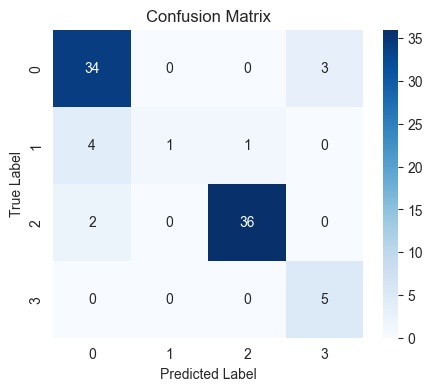

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = final_metrics['confusion_matrix']

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

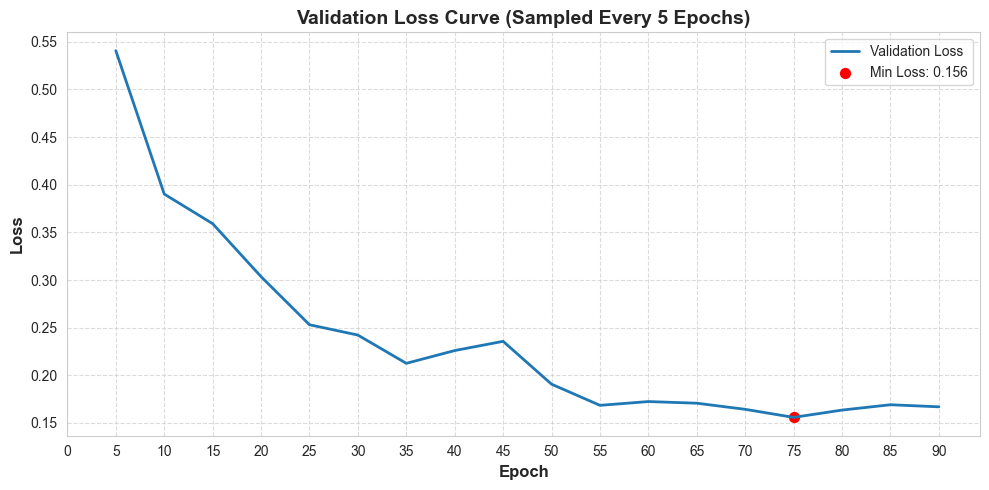

In [17]:
val_epochs = [5 * (i+1) for i in range(len(val_losses))]
plt.figure(figsize=(10, 5))
plt.plot(val_epochs, val_losses, linewidth=2, markersize=8,
         markeredgecolor='white', label='Validation Loss')
min_loss = min(val_losses)
min_epoch = val_epochs[val_losses.index(min_loss)]
plt.scatter(min_epoch, min_loss, s=200, c='red', marker='.',
            label=f'Min Loss: {min_loss:.3f}')
plt.title('Validation Loss Curve (Sampled Every 5 Epochs)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')
plt.xticks(np.arange(0, max(val_epochs)+1, 5))
plt.tight_layout()
plt.savefig('validation_loss_curve.png', dpi=300)
plt.show()

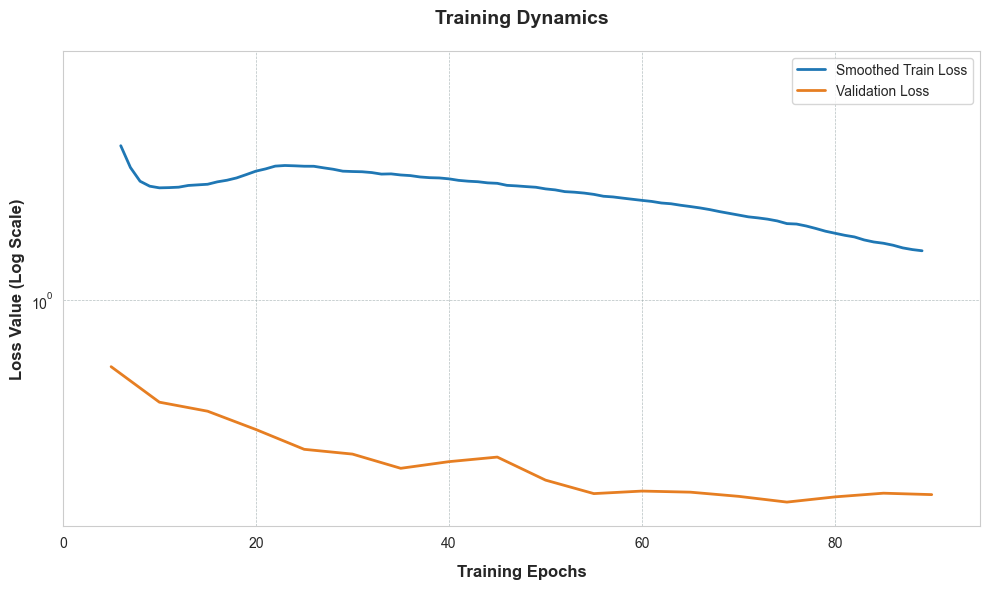

In [24]:
plt.figure(figsize=(10, 6))
ax1 = plt.gca()
window = 7
smooth_train = np.convolve(final_losses, np.ones(window)/window, mode='valid')
ax1.plot(range(window-1, len(final_losses)),
         smooth_train,
         color='#1f77b4',
         linewidth=2,
         label='Smoothed Train Loss')
val_x = np.arange(5, 5*len(val_losses)+1, 5)
ax1.plot(val_x, val_losses,
         markersize=8,
         markeredgecolor='white',
         color='#e67e22',
         linewidth=2,
         label='Validation Loss')
ax1.set_yscale('log')
ax1.set_xlabel('Training Epochs', fontsize=12, fontweight='bold', labelpad=10)
ax1.set_ylabel('Loss Value (Log Scale)', fontsize=12, fontweight='bold')
ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='#95a5a6')
ax1.legend(loc='upper right', frameon=True, fontsize=10, fancybox=True, shadow=False)
plt.title('Training Dynamics', fontsize=14, fontweight='bold', pad=20)  # 移除了"with KL Regularization"
ax1.set_xlim(0, len(final_losses)+5)
ax1.set_ylim(bottom=min(min(final_losses), min(val_losses))*0.8,
             top=max(max(final_losses), max(val_losses))*1.2)
plt.tight_layout()
plt.savefig('training_dynamics_curve.png', dpi=300, bbox_inches='tight')
plt.show()